## We choose a window of 60 time steps
## We want to learn 48 steps and predict 12 steps.
## Each step = 1 second

In [39]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence, split_sequence_long

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Exploration

In [2]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(1315800, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

1315800


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315800 entries, 0 to 1315799
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   pos.x       1315800 non-null  float64
 1   pos.y       1315800 non-null  float64
 2   pos.z       1315800 non-null  float64
 3   heading     1315800 non-null  float64
 4   velocity    1315800 non-null  float64
 5   weather     1315800 non-null  int64  
 6   Minute sin  1315800 non-null  float64
 7   Minute cos  1315800 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 80.3 MB


In [8]:
data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,-1.792514e-08,1.000000
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,1.045284e-01,0.994522
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2.079117e-01,0.978148
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,3.090170e-01,0.951057
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,4.067366e-01,0.913545


### Windowing
We choose a window of 60 time steps
We want to learn 48 steps and predict 12 steps.

In [9]:
window_size = 60
grouped_data = windowing_array(data, window_size)

In [10]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

21930
60
8


### Slice and Split sequence 

In [11]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [12]:
x_train_init.shape, x_test_init.shape

((17544, 60, 8), (4386, 60, 8))

In [13]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence_long(x_train_init)

In [14]:
x_train.shape, y_train.shape

((17544, 48, 8), (17544, 12, 8))

In [15]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [16]:
y_train.shape

(17544, 12, 2)

In [19]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence_long(x_test_init)

In [20]:
x_test.shape, y_test.shape

((4386, 48, 8), (4386, 12, 8))

In [21]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [22]:
y_test.shape

(4386, 12, 2)

### Model Configuration

In [23]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(48, 8)

In [24]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(12, 2)

In [27]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 2
output_features_vector=y_train_feature_nr * output_seq_size
output_features_vector

24

### Train and evaluate

In [28]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [30]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_vector, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [31]:
epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_long.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
439/439 [==============================] - 46s 93ms/step - loss: 1798.8838 - mae: 27.9653 - val_loss: 235.4875 - val_mae: 9.5311 - lr: 0.0010
Epoch 2/100
439/439 [==============================] - 39s 89ms/step - loss: 594.7179 - mae: 17.2939 - val_loss: 229.0410 - val_mae: 9.4709 - lr: 0.0010
Epoch 3/100
439/439 [==============================] - 39s 89ms/step - loss: 514.0638 - mae: 15.9356 - val_loss: 207.6801 - val_mae: 8.3778 - lr: 0.0010
Epoch 4/100
439/439 [==============================] - 39s 88ms/step - loss: 476.6121 - mae: 15.2649 - val_loss: 210.2096 - val_mae: 8.7787 - lr: 0.0010
Epoch 5/100
439/439 [==============================] - 38s 87ms/step - loss: 465.8350 - mae: 15.0765 - val_loss: 211.6938 - val_mae: 8.9718 - lr: 0.0010
Epoch 6/100
439/439 [==============================] - 41s 93ms/step - loss: 453.3037 - mae: 14.9312 - val_loss: 213.6444 - val_mae: 8.8472 - lr: 0.0010
Epoch 7/100
439/439 [==============================] - 38s 86ms/step - loss: 440.

In [33]:
#model.summary()

In [32]:
model = keras.models.load_model("best_model_long.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

138/138 [==============================] - 4s 27ms/step - loss: 183.3365 - mae: 8.2309
Test accuracy 8.230854988098145
Test loss 183.33651733398438


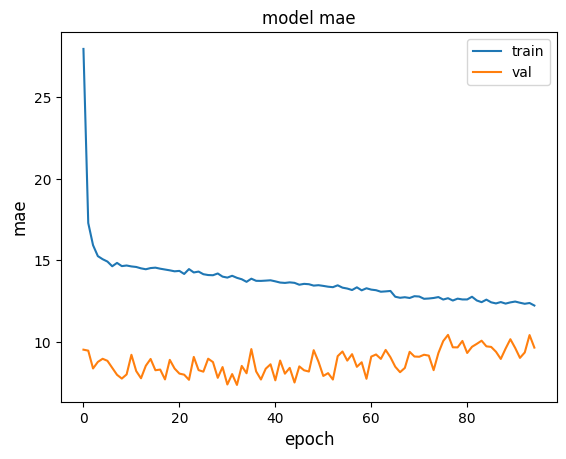

In [33]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [34]:
predictions = model.predict(x_test)

138/138 [==============================] - 4s 28ms/step


In [35]:
predictions.shape

(4386, 12, 2)

Visualize some few predictions


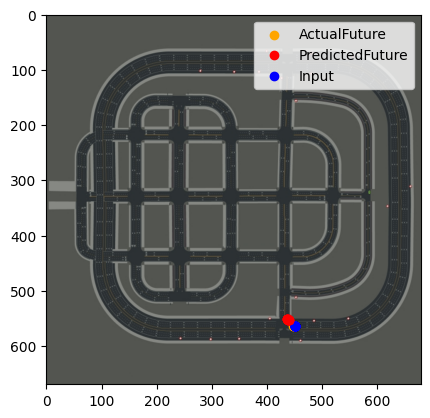

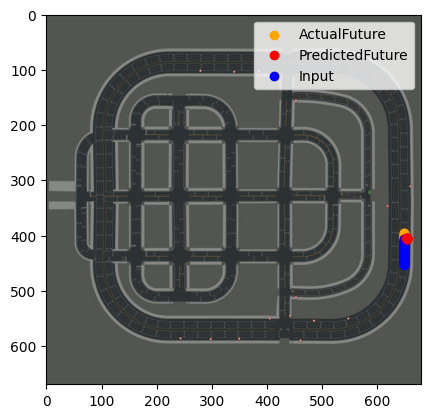

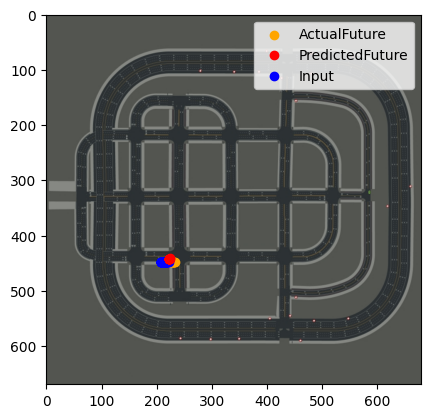

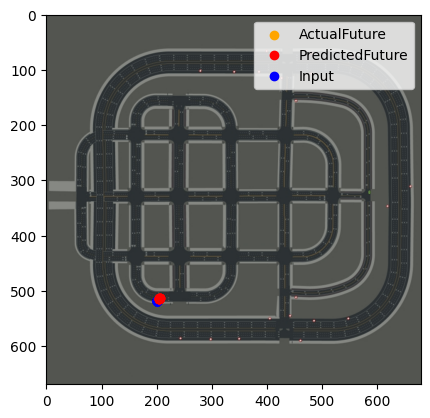

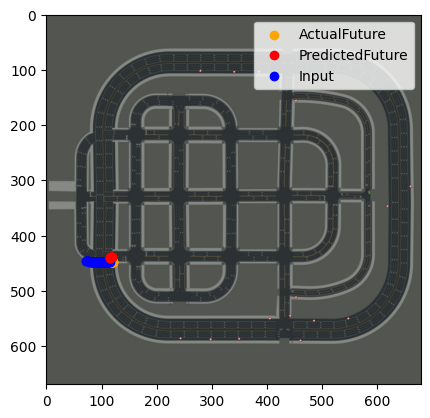

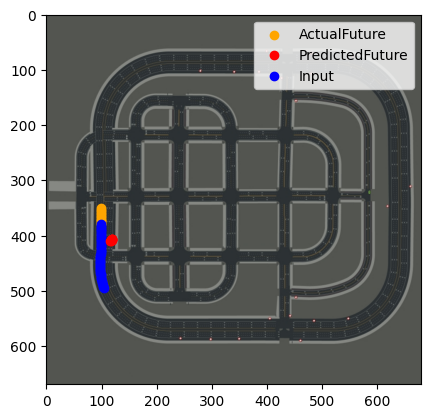

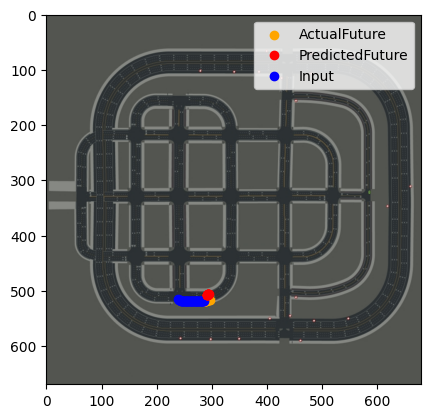

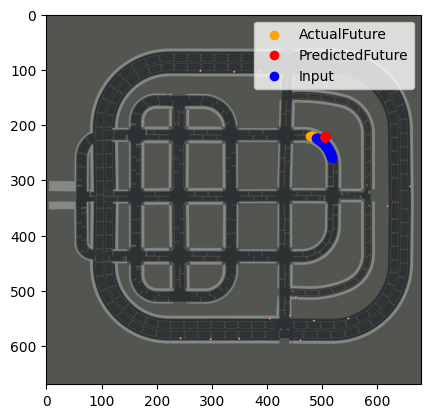

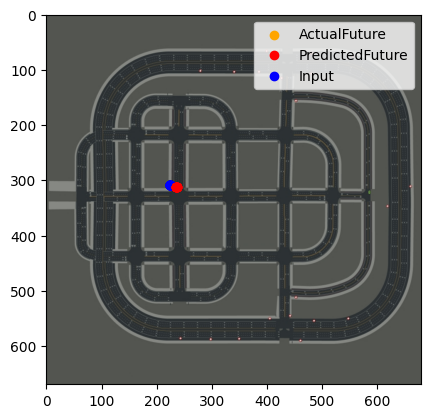

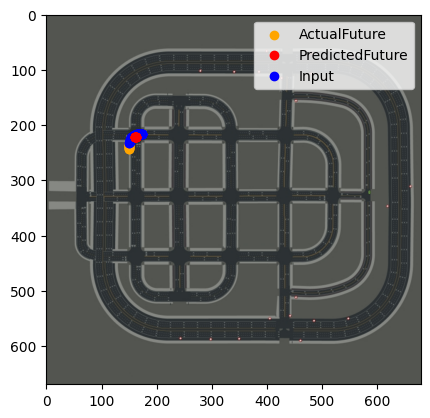

In [40]:
import random
from configs.utils_2 import plot_pred, plot_pred2


print("Visualize some few predictions")

# After finding the best prediction, visualize it
if x_test is not None and y_test is not None and predictions is not None:
    # This visualization will now only show the best prediction example
    for item in range(0, 10):
        index = random.randint(0, len(x_test[:, :, :2]))
        plot_pred2(x_test[:, :, :2][index], y_test[index], predictions[index])

## Explainer

### LIME

In [41]:
from lime import lime_tabular

In [42]:
explainer = lime_tabular.RecurrentTabularExplainer(
    x_train, 
    training_labels=y_train, 
    feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"],
    discretize_continuous=True,
    class_names=['pos.x', 'pos.y'],
    discretizer='decile')

In [43]:
exp = explainer.explain_instance(x_test[0], model.predict, num_features=10, labels=(0,))
exp.show_in_notebook()

157/157 [==============================] - 4s 27ms/step


ValueError: Your model outputs arrays with 3 dimensions

In [44]:
exp = explainer.explain_instance(x_test[0], model.predict, num_features=10, labels=(1,))
exp.show_in_notebook()

157/157 [==============================] - 4s 27ms/step


ValueError: Your model outputs arrays with 3 dimensions

### Shape

In [45]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [46]:
x_test_0 = x_test[0]
x_train_0 = x_train[0]

In [47]:
x_test_0.shape, x_train_0.shape

((48, 8), (48, 8))

In [48]:
predictions.shape

(4386, 12, 2)

In [49]:
from explainers.explainer import BlackBoxWrapper


myBlackbox = BlackBoxWrapper(model)

In [50]:
explainer = shap.KernelExplainer(model=myBlackbox.predict, data=x_train_0, feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"])

2/2 [==============================] - 0s 7ms/step


In [51]:
shap_values = explainer.shap_values(x_test_0)

  0%|          | 0/48 [00:00<?, ?it/s]

381/381 [==============================] - 3s 7ms/step


ValueError: cannot reshape array of size 292608 into shape (12192,12)

In [52]:
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_0)

NameError: name 'shap_values' is not defined

In [53]:
shap.summary_plot(shap_values, x_test_0)

NameError: name 'shap_values' is not defined

In [54]:
shap.dependence_plot("Feature 1", shap_values[0], x_test_0)

NameError: name 'shap_values' is not defined

### Lime-For-Time

In [55]:
num_background = 50
num_test = 28
background_data, test_data = x_train[:num_background], x_test[num_test:num_test+2]

In [56]:
import logging
import numpy as np

from sklearn.pipeline import Pipeline

from sktime.classification.interval_based import TimeSeriesForestClassifier

from sktime.transformations.panel.compose import ColumnConcatenator

import matplotlib.pyplot as plt

from lime import explanation
from lime import lime_base
import explainers.lime_timeseries as lime_ts

In [57]:
def testlime(signal_names, clf, x, exclass1, exclass2, labelId):
    class_names=[exclass1, exclass2]

    num_slices=20
    num_features=10

    explainer = lime_ts.LimeTimeSeriesExplainer(class_names=class_names,
                                                signal_names=signal_names)

    labelid = labelId
    exp = explainer.explain_instance(x, clf.predict, num_features=num_features, num_samples=100, num_slices=num_slices, labels=[labelid], replacement_method='total_mean')
    exp.as_pyplot_figure(labelid)
    plt.show()

In [61]:
x_test[0].shape

(48, 8)

In [58]:
testlime(["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"], model, x_test[0], "pos.x", "pos.y", 0)

4/4 [==============================] - 0s 19ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()